In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [26]:
df = pd.read_csv('../data/arl_ready_feature.csv')

In [27]:
# One-hot encode the 'hour' column
hour_encoded = pd.get_dummies(df["hour"], prefix="is_hour", dtype=int)

# Concatenate the new one-hot encoded columns to the original dataframe
df = pd.concat([df, hour_encoded], axis=1)

# Drop the original 'hour' column
df = df.drop("hour", axis=1)

peak_hours = ["is_hour_7", "is_hour_8", "is_hour_17", "is_hour_18"]
df["is_peak_time"] = df[peak_hours].max(axis=1)

# print("Added 'is_peak_time' column.")
display(df[['is_hour_7', 'is_hour_8', 'is_hour_17', 'is_hour_18', 'is_peak_time']].head())

,is_hour_7,is_hour_8,is_hour_17,is_hour_18,is_peak_time
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [28]:
print("Columns in the dataframe:")
print(df.columns.tolist())

Columns in the dataframe:
['is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday', 'is_Friday', 'is_Saturday', 'is_Sunday', 'is_A1', 'is_A2', 'is_A3', 'is_A4', 'is_A5', 'is_A6', 'is_A7', 'is_A8', 'passenger_origin', 'is_holiday', 'is_weekend', 'is_festival', 'rain_flag', 'cloudcover', 'temp', 'temp_bin', 'temp_range', 'is_hour_5', 'is_hour_6', 'is_hour_7', 'is_hour_8', 'is_hour_9', 'is_hour_10', 'is_hour_11', 'is_hour_12', 'is_hour_13', 'is_hour_14', 'is_hour_15', 'is_hour_16', 'is_hour_17', 'is_hour_18', 'is_hour_19', 'is_hour_20', 'is_hour_21', 'is_hour_22', 'is_hour_23', 'is_peak_time']


In [6]:
# Remove rows where 'passenger_origin' is 0
df = df[df['passenger_origin'] != 0]

import numpy as np
y = np.log1p(df['passenger_origin'])
X = df.drop(['passenger_origin', 'temp_bin', 'temp_range','cloudcover','is_festival'], axis=1)

In [7]:
# Get the original 'passenger_origin' column from the dataframe
original_passenger_origin = df['passenger_origin']

# The 'y' variable already contains the log1p transformed 'passenger_origin'
log1p_passenger_origin = y

# Create a DataFrame to display both values
comparison_df = pd.DataFrame({
    'Original Passenger Origin': original_passenger_origin,
    'Log1p Transformed Passenger Origin': log1p_passenger_origin
})

print("Comparison of Original and Log1p Transformed Passenger Origin:")
display(comparison_df.head())


Comparison of Original and Log1p Transformed Passenger Origin:


,Original Passenger Origin,Log1p Transformed Passenger Origin
0,312,5.746203
1,172,5.153292
2,48,3.891820
3,66,4.204693
4,97,4.584967


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (44368, 39)
X_test shape: (11093, 39)
y_train shape: (44368,)
y_test shape: (11093,)


XGBoost Mean Squared Error (Original Scale): 9501.145939908994
XGBoost Root Mean Squared Error (Original Scale): 97.4738218185221
XGBoost R-squared (Log1p Scale): 0.924753378353376

Feature Coefficients (Sorted by Absolute Value):


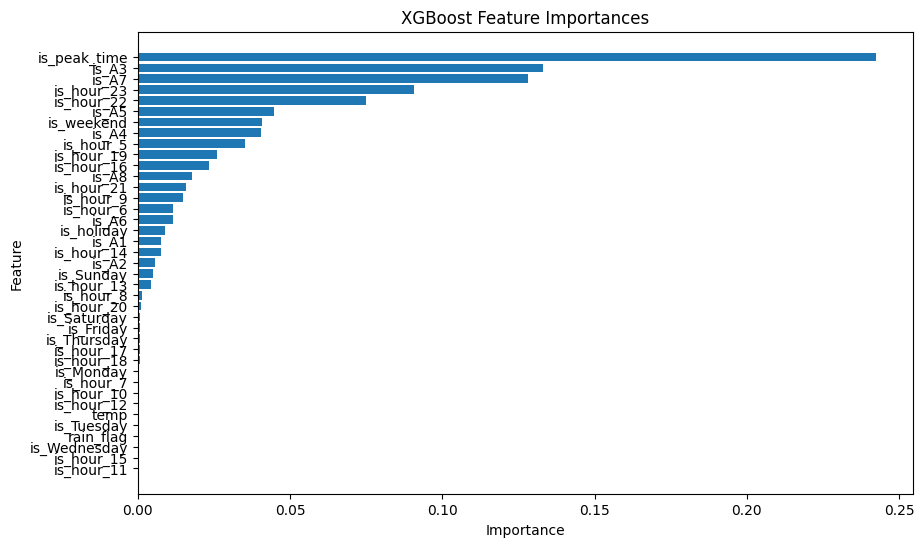

In [9]:
# Initialize and train the XGBoost Regressor model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Convert y_test and y_pred_xgb back to original scale for MSE and RMSE calculation
y_test_original_xgb = np.expm1(y_test)
y_pred_xgb_original = np.expm1(y_pred_xgb)

# Evaluate the model on original scale for MSE and RMSE
mse_xgb = mean_squared_error(y_test_original_xgb, y_pred_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
# R-squared is often more meaningful on the transformed scale for models trained on it
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (Original Scale): {mse_xgb}")
print(f"XGBoost Root Mean Squared Error (Original Scale): {rmse_xgb}")
print(f"XGBoost R-squared (Log1p Scale): {r2_xgb}")

# Get feature importances
feature_importances_xgb = xgb_model.feature_importances_

# Create a pandas DataFrame for better visualization
features_xgb_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_xgb})

# Sort features by importance in descending order
features_xgb_df = features_xgb_df.sort_values(by='Importance', ascending=False)

print("\nFeature Coefficients (Sorted by Absolute Value):")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(features_xgb_df['Feature'], features_xgb_df['Importance'])
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # ให้ feature ที่สำคัญที่สุดอยู่บนสุด
plt.show()

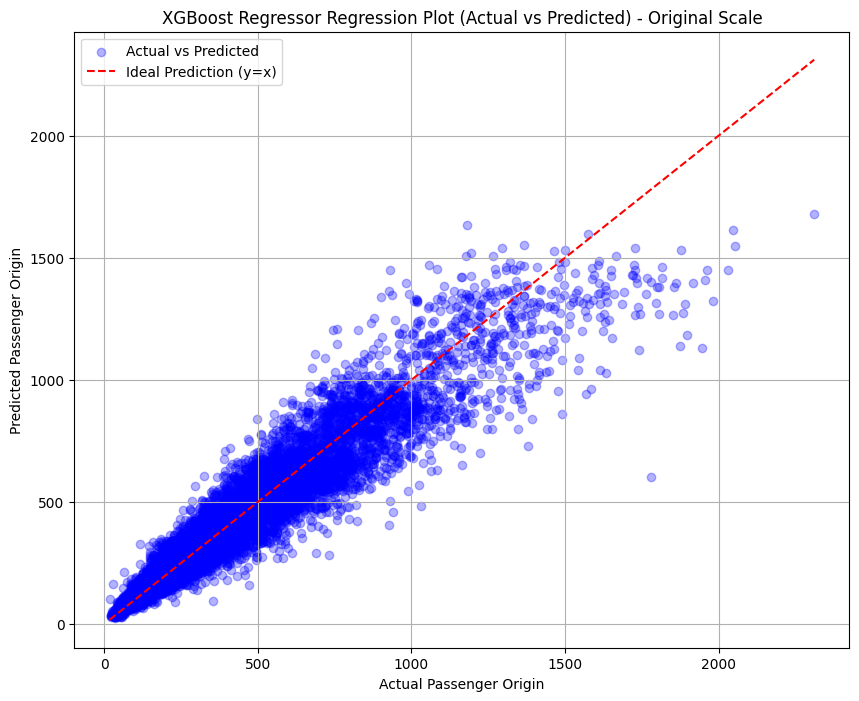

In [10]:
import matplotlib.pyplot as plt

def plot_regression_matplotlib(y_true_orig, y_pred_orig, model_name):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.3, color='blue', label='Actual vs Predicted')
    plt.title(f"{model_name} Regression Plot (Actual vs Predicted) - Original Scale")
    plt.xlabel('Actual Passenger Origin')
    plt.ylabel('Predicted Passenger Origin')

    # Add the diagonal line (y=x)
    min_val = min(y_true_orig.min(), y_pred_orig.min())
    max_val = max(y_true_orig.max(), y_pred_orig.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction (y=x)')

    plt.legend()
    plt.grid(True)
    plt.show()

# ใช้ plot
plot_regression_matplotlib(y_test_original_xgb, y_pred_xgb_original, "XGBoost Regressor")

In [11]:
mae = mean_absolute_error(y_test_original_xgb, y_pred_xgb_original)
mse = mean_squared_error(y_test_original_xgb, y_pred_xgb_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)  # R² บน log1p scale

# แสดงผล
print("=== Model Evaluation ===")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")

=== Model Evaluation ===
MAE  : 64.19
MSE  : 9501.15
RMSE : 97.47
R²   : 0.92


In [38]:
import requests

API_URL = "https://api.iapp.co.th/data/thai-holidays/holidays"
API_KEY = "PCx7qg91X4Obd4wEbz2X2loOrIO5Q5st"

def get_thai_holidays(days_after=3):
    """
    ดึงรายการวันหยุดไทยจาก API iApp
    :param days_after: จำนวนวันหลังจากวันนี้ที่ต้องการดึงข้อมูล
    :return: dict {date_string: holiday_name} เช่น {"2025-01-01": "วันปีใหม่"}
    """
    params = {
        "apikey": API_KEY,
        "days_after": days_after
    }

    try:
        response = requests.get(API_URL, params=params)
        response.raise_for_status()
        data = response.json()

        # สมมติ data['holidays'] เป็น list ของ dict ที่มี 'date' และ 'name'
        holidays = {item["date"]: item["name"] for item in data.get("holidays", [])}
        return holidays
    except requests.RequestException as e:
        print("Error while calling API:", e)
        return {}

if __name__ == "__main__":
    holidays = get_thai_holidays()
    print("จำนวนวันหยุด:", len(holidays))
    print(holidays)


จำนวนวันหยุด: 0
{}
